In [46]:
# ==================
# Libraries
# ==================
import pickle
from pathlib import Path
import os
import random
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch
import logging
from contextlib import contextmanager
import time
import sys
import numpy as np
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [47]:
# =========================
# Constants
# =========================
OUTPUT_DIR = Path("../storage/leap/output")
DATA_DIR = Path("../storage/leap/data")

ptend_t = [f'ptend_t_{i}' for i in range(60)]
ptend_q0001 = [f'ptend_q0001_{i}' for i in range(60)]
ptend_q0002 = [f'ptend_q0002_{i}' for i in range(60)]
ptend_q0003 = [f'ptend_q0003_{i}' for i in range(60)]
ptend_u = [f'ptend_u_{i}' for i in range(60)]
ptend_v = [f'ptend_v_{i}' for i in range(60)]

target_cols = ['ptend_t', 'ptend_q0001', 'ptend_q0002', 'ptend_q0003',
               'ptend_u', 'ptend_v']
other_target_cols = ['cam_out_NETSW', 'cam_out_FLWDS',
                     'cam_out_PRECSC', 'cam_out_PRECC', 'cam_out_SOLS',
                     'cam_out_SOLL', 'cam_out_SOLSD', 'cam_out_SOLLD']


In [48]:
# =========================
# Settings
# =========================
exp = "140"
exp_dir = OUTPUT_DIR / "exp" / f"ex{exp}"
model_dir = exp_dir / "model"
logger_path = exp_dir / f"ex{exp}.txt"

In [49]:
LOGGER = logging.getLogger()
FORMATTER = logging.Formatter("%(asctime)s - %(levelname)s - %(message)s")


def setup_logger(out_file=None, stderr=True,
                 stderr_level=logging.INFO, file_level=logging.DEBUG):
    LOGGER.handlers = []
    LOGGER.setLevel(min(stderr_level, file_level))

    if stderr:
        handler = logging.StreamHandler(sys.stderr)
        handler.setFormatter(FORMATTER)
        handler.setLevel(stderr_level)
        LOGGER.addHandler(handler)

    if out_file is not None:
        handler = logging.FileHandler(out_file)
        handler.setFormatter(FORMATTER)
        handler.setLevel(file_level)
        LOGGER.addHandler(handler)

    LOGGER.info("logger set up")
    return LOGGER


@contextmanager
def timer(name):
    t0 = time.time()
    yield
    LOGGER.info(f'[{name}] done in {time.time() - t0:.0f} s')


setup_logger(out_file=logger_path)

2024-07-04 23:47:19,985 - INFO - logger set up


<RootLogger root (DEBUG)>

In [50]:
weight_old = np.load(DATA_DIR / "old" / "old_sample_weight.npy",allow_pickle=True)
sub = pd.read_csv(DATA_DIR / "sample_submission.csv")

In [51]:
weight_old == 0

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True,  True,  True,  True,  True,  True,
        True,  True,

In [52]:
new_weight = sub.iloc[0,1:].values

In [53]:
new_weight

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,

In [54]:
# =====================
# Main
# =====================
test_pred = pd.read_parquet(OUTPUT_DIR / "exp" / "ex124" / f"ex123_124_ensemble.parquet")
test_old_ = pd.read_parquet(OUTPUT_DIR / "exp" / "ex140" / f"ex140_pp.parquet")
test_old = pd.read_parquet(OUTPUT_DIR / "exp" / "latlon0808" / f"20240707_ensemble_nelder_mead2.parquet")

In [55]:
len(new_weight)

368

In [56]:
for n,(wo,wn) in tqdm(enumerate(zip(weight_old,new_weight))):
    if wo != 0:
        test_old.iloc[:,n + 1] = (test_old.iloc[:,n + 1] / wo) * wn

368it [00:00, 1039.13it/s]


In [57]:
test_old

,sample_id,ptend_t_0,ptend_t_1,ptend_t_2,ptend_t_3,ptend_t_4,ptend_t_5,ptend_t_6,ptend_t_7,ptend_t_8,...,ptend_v_58,ptend_v_59,cam_out_NETSW,cam_out_FLWDS,cam_out_PRECSC,cam_out_PRECC,cam_out_SOLS,cam_out_SOLL,cam_out_SOLSD,cam_out_SOLLD
0,test_169651,-0.000011,-0.000026,-0.000023,-0.000045,-0.000080,-0.000107,-0.000103,-0.000082,-0.000054,...,-6.696152e-06,0.000007,-4.123798,397.168768,-1.000704e-10,-4.053596e-10,-0.287952,-0.810254,0.065429,-0.359230
1,test_524862,-0.000009,-0.000021,-0.000024,-0.000046,-0.000084,-0.000112,-0.000104,-0.000079,-0.000053,...,-9.534779e-06,0.000024,-1.208668,385.492575,-8.792407e-12,1.454177e-08,-0.106443,-0.850254,-0.023858,-0.166294
2,test_634129,-0.000011,-0.000049,-0.000034,-0.000047,-0.000074,-0.000103,-0.000105,-0.000083,-0.000050,...,5.789434e-07,-0.000002,-0.456533,419.240787,1.677870e-11,-7.134626e-10,-0.404969,-1.056877,0.469794,0.404092
3,test_403572,-0.000012,-0.000039,-0.000030,-0.000043,-0.000073,-0.000108,-0.000108,-0.000082,-0.000049,...,-2.402907e-06,-0.000007,0.208831,418.266516,6.837290e-11,8.735888e-09,-0.371292,-1.343327,0.481996,0.166378
4,test_484578,-0.000008,-0.000014,-0.000022,-0.000049,-0.000087,-0.000116,-0.000107,-0.000079,-0.000051,...,2.895053e-05,-0.000002,1.847482,377.663084,6.994921e-11,8.687380e-09,0.644036,0.533096,0.858633,0.543718
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
624763,test_27159,-0.000022,-0.000033,-0.000059,-0.000067,-0.000103,-0.000089,-0.000059,-0.000037,-0.000026,...,1.613661e-06,0.000052,-6.518175,312.928138,5.294019e-08,8.731015e-08,-3.679809,-3.858174,-1.022982,-0.464298
624764,test_597033,-0.000007,-0.000033,-0.000060,-0.000099,-0.000121,-0.000098,-0.000064,-0.000045,-0.000031,...,2.850494e-07,-0.000001,-3.154431,151.105051,1.016189e-09,5.857329e-10,-1.004378,1.047519,1.404130,0.618718
624765,test_213555,-0.000008,-0.000041,-0.000065,-0.000082,-0.000090,-0.000093,-0.000065,-0.000044,-0.000031,...,-1.249621e-05,0.000007,-8.419063,172.880735,4.386789e-11,-1.403257e-09,-2.006525,-1.023805,-0.059112,-0.324940
624766,test_328713,-0.000013,-0.000019,-0.000033,-0.000069,-0.000107,-0.000098,-0.000063,-0.000035,-0.000026,...,3.217529e-06,-0.000049,0.592529,246.666867,7.076220e-09,7.253719e-09,-0.162049,1.059918,-0.115535,-0.056730


In [58]:
test_old_

,sample_id,ptend_t_0,ptend_t_1,ptend_t_2,ptend_t_3,ptend_t_4,ptend_t_5,ptend_t_6,ptend_t_7,ptend_t_8,...,ptend_v_58,ptend_v_59,cam_out_NETSW,cam_out_FLWDS,cam_out_PRECSC,cam_out_PRECC,cam_out_SOLS,cam_out_SOLL,cam_out_SOLSD,cam_out_SOLLD
0,test_169651,-0.000011,-0.000025,-0.000022,-0.000045,-0.000079,-0.000104,-0.000099,-0.000081,-0.000052,...,-7.655163e-06,6.931148e-06,0.857468,386.207825,1.392550e-11,-6.257073e-11,0.200987,0.200848,0.081516,0.016740
1,test_524862,-0.000008,-0.000020,-0.000023,-0.000046,-0.000083,-0.000109,-0.000101,-0.000078,-0.000051,...,-9.727579e-06,2.282611e-05,0.541409,373.023651,3.145222e-11,1.110765e-08,0.103360,0.211868,0.054986,-0.012079
2,test_634129,-0.000011,-0.000048,-0.000034,-0.000046,-0.000072,-0.000100,-0.000102,-0.000081,-0.000048,...,4.838178e-07,-1.967104e-06,0.203972,410.986450,-4.060980e-12,1.939444e-10,0.162489,-0.297604,0.111980,0.101701
3,test_403572,-0.000012,-0.000038,-0.000029,-0.000042,-0.000072,-0.000105,-0.000105,-0.000080,-0.000047,...,-2.354557e-06,-6.415552e-06,0.134727,412.974396,6.993472e-12,1.068285e-08,0.060407,-0.305539,0.076488,-0.007987
4,test_484578,-0.000008,-0.000013,-0.000021,-0.000049,-0.000087,-0.000113,-0.000104,-0.000077,-0.000050,...,2.594266e-05,-1.163521e-06,0.499520,368.680939,1.262555e-11,5.981359e-09,0.132612,0.146261,-0.070233,0.013281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
624763,test_27159,-0.000023,-0.000032,-0.000057,-0.000064,-0.000101,-0.000088,-0.000057,-0.000035,-0.000025,...,6.459401e-07,5.133880e-05,-1.837333,306.551666,5.590175e-08,9.242891e-08,-1.738393,-1.103890,-0.243434,-0.151341
624764,test_597033,-0.000007,-0.000033,-0.000058,-0.000095,-0.000118,-0.000095,-0.000063,-0.000044,-0.000030,...,1.108396e-07,-7.948680e-07,-0.601501,143.790970,4.944765e-10,6.294571e-10,-0.981037,-0.309465,0.601751,0.404011
624765,test_213555,-0.000008,-0.000042,-0.000064,-0.000079,-0.000086,-0.000090,-0.000064,-0.000043,-0.000030,...,-1.262326e-05,6.177378e-06,0.112420,171.010315,-1.214670e-10,3.320903e-11,-0.239936,-0.354504,0.207808,-0.070277
624766,test_328713,-0.000013,-0.000019,-0.000033,-0.000067,-0.000105,-0.000096,-0.000061,-0.000034,-0.000024,...,3.045223e-06,-4.949178e-05,0.109210,242.904053,7.736209e-09,7.966582e-09,-0.068360,0.155739,-0.128322,0.075834


In [59]:
match = pd.read_parquet(OUTPUT_DIR / "fe" / "fe177" / "test_old_test_match.parquet")

In [60]:
match = match[match["new_sample_id"].notnull()].reset_index(drop=True)

In [61]:
match["ind"] = np.arange(len(match))

In [62]:
test_pred_ = test_pred[test_pred["sample_id"].isin(match["new_sample_id"].values)].reset_index(drop=True)
test_old_pred_ = test_old[test_old["sample_id"].isin(match["sample_id"].values)].reset_index(drop=True)

In [63]:
test_pred_ = test_pred_.merge(match[["new_sample_id","ind"]].rename(columns={"new_sample_id":"sample_id"})
                              ,how="left",on="sample_id")

In [64]:
test_old_pred_ = test_old_pred_.merge(match[["sample_id","ind"]],how="left",on="sample_id")
test_pred_ = test_pred_.sort_values(by="ind").reset_index(drop=True)
test_old_pred_ = test_old_pred_.sort_values(by="ind").reset_index(drop=True)

In [67]:
r2_score_list = []
for i in range(1,370):
    r2_ = r2_score(test_old_pred_.iloc[:,i],
                  test_pred_ .iloc[:,i])
    if r2_ < 0.2:
        print(i,r2_)
        test_old_pred_.iloc[:,i] = test_pred_.iloc[:,i]
    r2_score_list.append(r2_score(test_old_pred_.iloc[:,i],
                  test_pred_ .iloc[:,i]))

133 0.0
134 0.0
135 0.0


In [68]:
len(test_pred_.columns)

370

(array([  1.,   2.,   1.,  10.,  20.,  29.,  23.,  54.,  76., 153.]),
 array([0.81902808, 0.83712527, 0.85522246, 0.87331966, 0.89141685,
        0.90951404, 0.92761123, 0.94570842, 0.96380562, 0.98190281,
        1.        ]),
 <BarContainer object of 10 artists>)

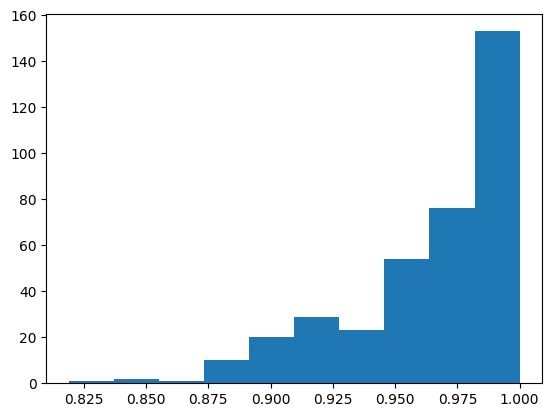

In [69]:
plt.hist(r2_score_list)

In [70]:
match_dict = {}
new_sample_id = match["new_sample_id"].values
old_sample_id = match["sample_id"].values
for n,o in tqdm(zip(new_sample_id,old_sample_id)):
    match_dict[o] = n

125184it [00:00, 3404019.22it/s]


In [71]:
test_old_pred_["sample_id"] = test_old_pred_["sample_id"].map(match_dict)

In [73]:
test_old_pred_ = test_old_pred_.drop("ind",axis=1)
test_pred = test_pred[~test_pred["sample_id"].isin(test_old_pred_["sample_id"].values)].reset_index(drop=True)
test_pred = pd.concat([test_pred,test_old_pred_]).reset_index(drop=True)

In [74]:
test_pred["sample_id"].value_counts()

test_0         1
test_731475    1
test_731466    1
test_731468    1
test_731469    1
              ..
test_41617     1
test_416171    1
test_416172    1
test_416173    1
test_708869    1
Name: sample_id, Length: 625000, dtype: int64

In [75]:
test_pred.to_parquet(OUTPUT_DIR / "exp" / "ex140" / f"exensemble0808_123_124_ensemble.parquet")